In [1]:
import scanpy as sc
import scanpy.external as sce

import numpy as np
import pandas as pd

import os
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

import plotnine as pn
import re

In [2]:
current_folder = globals()['_dh'][0]
raw_out = current_folder / ".." / ".." / "data" / "raw_old_sn"
cellbender_out = current_folder / ".." / ".." / "data" / "cellbender_out"
uscsc_out = current_folder / ".." / ".." / "data" / "uscsc_dump"
plot_out = current_folder / ".." / ".." / "out" / "cellbender_cellranger_comparison"
plot_out.mkdir(parents=True, exist_ok=True)
sc._settings.ScanpyConfig.figdir = plot_out

In [3]:
samples = [sample for sample in os.listdir(cellbender_out) if not sample.startswith(".")]
adata_objects = {sample: sc.read_h5ad(cellbender_out / sample / "cell_bender_matrix_filtered_qc_annotated.h5ad") for sample in samples}
adata_objects_forced = {sample: sc.read_h5ad(cellbender_out / sample / "cell_bender_matrix_filtered_qc_annotated_forced.h5ad") for sample in samples}
adata_cellbender = sc.concat(list(adata_objects.values()), join="outer", label="sample_id", keys=list(adata_objects.keys()))
adata_cellbender.obs.index = [smp + "_" + bc for smp, bc in zip(adata_cellbender.obs["sample_id"], adata_cellbender.obs.index)]
adata_cellbender.obs.head()

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,doublet_score,predicted_doublet,diss_score,cell_type,cell_type_forced,leiden,leiden_forced,sample_id
MS411_TCCACCACAGCTTCCT-1,5445,5444,21537,23,0.106793,0.163212,False,0.245685,Oligos,Oligos,Oligos,Oligos,MS411
MS411_AGCTTCCAGGTGTGAC-1,5036,5031,21214,107,0.504384,0.022673,False,0.184244,Oligos,Oligos,Oligos,Oligos,MS411
MS411_CATACTTTCATTACGG-1,5271,5270,21036,2,0.009508,0.008456,False,0.227905,Oligos,Oligos,Oligos,Oligos,MS411
MS411_CACGAATGTCTCTCCA-1,4909,4907,20661,0,0.000000,0.014815,False,0.182494,Oligos,Oligos,Oligos,Oligos,MS411
MS411_AACACACAGTAGAATC-1,5552,5551,20274,27,0.133175,0.183381,False,0.232755,Oligos,Oligos,Oligos,Oligos,MS411


In [4]:
adata_cellranger = sc.read_h5ad(uscsc_out / "annotated.h5ad")
adata_cellranger.obs.index = [re.sub("-[0-9]+$", "", barcode) for barcode in adata_cellranger.obs.index]
adata_cellranger.obs.index = [smp + "_" + bc for smp, bc in zip(adata_cellranger.obs["sample_id"], adata_cellranger.obs.index)]
adata_cellranger

AnnData object with n_obs × n_vars = 69526 × 3000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'diss_score', 'patient_id', 'sample_id', 'lesion_type', 'spots_detected', 'total_genes', 'prop_reads_in_spots', 'median_genes', 'median_UMI', 'seq_saturation', 'rin', 'sex', 'age', 'duration_disease', 'batch', 'leiden', 'cell_type'
    var: 'highly_variable', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# add comparison column to obs
adata_cellranger.obs["in_cellbender_out"] = np.isin(adata_cellranger.obs.index.to_numpy(), adata_cellbender.obs.index.to_numpy())
adata_cellbender.obs["in_cellranger_out"] = np.isin(adata_cellbender.obs.index.to_numpy(), adata_cellranger.obs.index.to_numpy())

In [6]:
# reading in the unfiltered data
adata_raw = []
for sample in samples:
    print(sample)
    barcodes_oi = set([re.sub("^" + sample + "_", "", s) for s in adata_cellbender.obs_names[adata_cellbender.obs["sample_id"] == sample]]) | \
        set([re.sub("^" + sample + "_", "", s) for s in adata_cellranger.obs_names[adata_cellranger.obs["sample_id"] == sample]])
    barcodes_oi = np.array(list(barcodes_oi))
    adata = sc.read_10x_h5(raw_out / sample / "raw_feature_bc_matrix.h5")
    adata = adata[barcodes_oi, :]
    adata.var_names_make_unique()
    adata.obs.index = [sample + "_" + bc for bc in adata.obs.index]
    adata_raw.append(adata)
adata_raw = sc.concat(adata_raw, join="outer", label="sample_id", keys=samples)

MS411


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


MS466


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


MS497T


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CO74


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


MS377I


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


MS377T


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


MS549T


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


MS497I


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CO85


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CO40


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


MS549H


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
# compute QC metrics
adata_raw.var['mt'] = adata_raw.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_raw, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Compute doublets score
sce.pp.scrublet(adata_raw, verbose=False)

# Compute dissociation score and normalize it (0-1)
diss_path = "https://raw.githubusercontent.com/kieranrcampbell/scrnaseq-digestion-paper/master/data/deliverables/coregene_df-FALSE-v3.csv"
diss_genes = pd.read_csv(diss_path).sort_values('PValue').head(200).gene_symbol.tolist()
intersect_genes = adata_raw.var.index.intersection(diss_genes)
if len(intersect_genes) > 1:
    sc.tl.score_genes(adata_raw, gene_list=intersect_genes, ctrl_size=len(intersect_genes), 
                        score_name='diss_score')
    adata_raw.obs['diss_score'] = (adata_raw.obs.diss_score-np.min(adata_raw.obs.diss_score)) / \
    (np.max(adata_raw.obs.diss_score) - np.min(adata_raw.obs.diss_score))
else:
    adata_raw.obs['diss_score'] = 0


/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.


In [8]:
# check whether a barcode/cell is present in cellranger, cellbender or both
adata_raw.obs["in_cellranger_out"] = np.isin(adata_raw.obs.index.to_numpy(), adata_cellranger.obs.index.to_numpy())
adata_raw.obs["in_cellbender_out"] = np.isin(adata_raw.obs.index.to_numpy(), adata_cellbender.obs.index.to_numpy())
adata_raw.obs["in_both"] = np.logical_and(adata_raw.obs["in_cellranger_out"], adata_raw.obs["in_cellbender_out"])

In [9]:
cell_labels = []
# loop through the rows of the dataframe
for i, row in adata_raw.obs.iterrows():
    if row["in_both"]:
        cell_labels.append("both")
    elif row["in_cellranger_out"]:
        cell_labels.append("only_cellranger")
    elif row["in_cellbender_out"]:
        cell_labels.append("only_cellbender")
    else:
        raise ValueError("This should not happen")
adata_raw.obs["label"] = cell_labels

# Global Comparison (based on raw data)

In [10]:
adata_raw.obs.value_counts("label")

label
both               63635
only_cellbender    12232
only_cellranger     5891
Name: count, dtype: int64

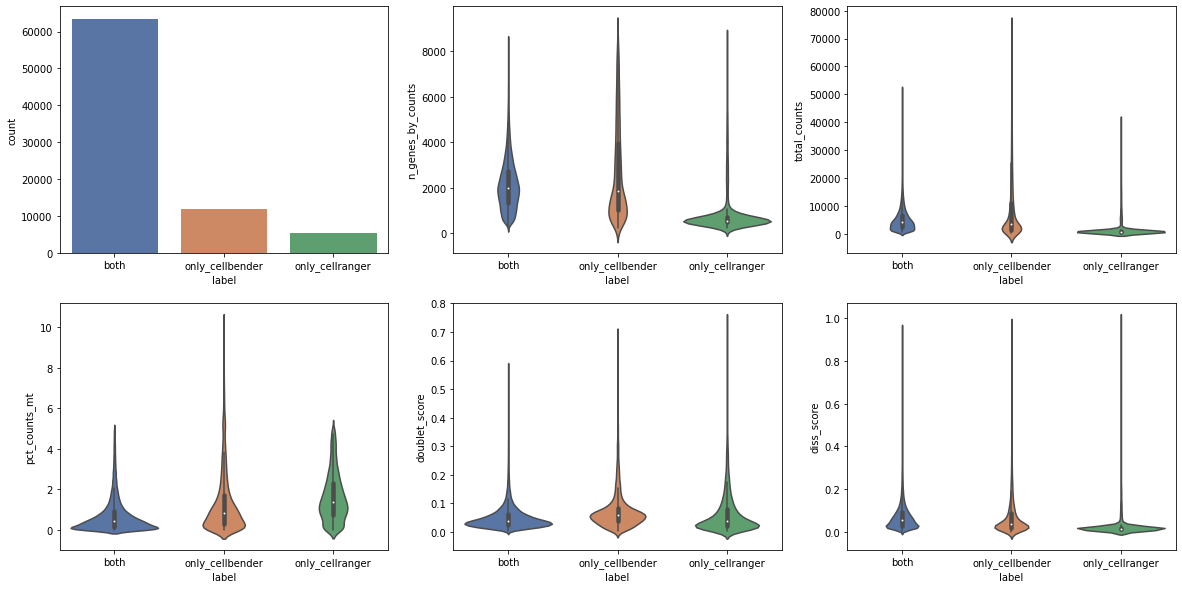

In [11]:
fig, axis = plt.subplots(2, 3, figsize=(20, 10))
sns.set_theme(style="whitegrid")
sns.countplot(data=adata_raw.obs, x="label", ax=axis[0, 0])
sns.violinplot(data=adata_raw.obs, x="label", y="n_genes_by_counts", ax=axis[0, 1])
sns.violinplot(data=adata_raw.obs, x="label", y="total_counts", ax=axis[0, 2])
sns.violinplot(data=adata_raw.obs, x="label", y="pct_counts_mt", ax=axis[1, 0])
sns.violinplot(data=adata_raw.obs, x="label", y="doublet_score", ax=axis[1, 1])
sns.violinplot(data=adata_raw.obs, x="label", y="diss_score", ax=axis[1, 2])
plt.savefig(plot_out / "global_comparison.png", dpi=300)
plt.show()

# Comparison per Sample (based on post QC)

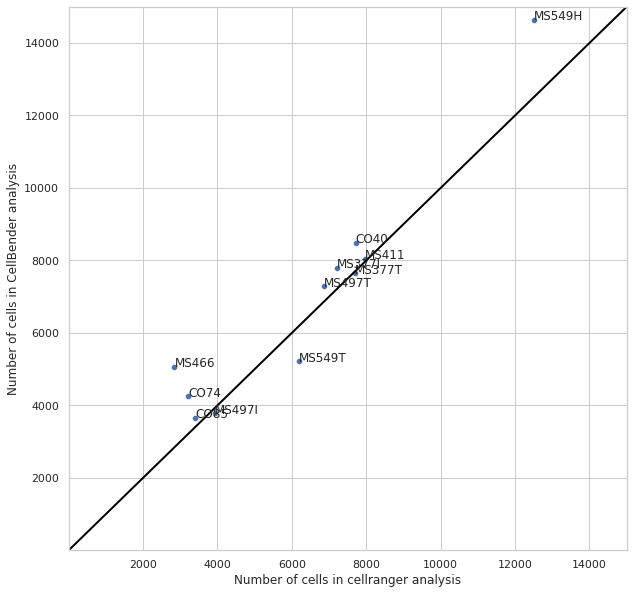

In [12]:
df = adata_cellranger.obs.sample_id.value_counts().to_frame().reset_index().rename(columns={"count": "n_cellranger"}).merge(
    adata_cellbender.obs.sample_id.value_counts().to_frame().reset_index().rename(columns={"count": "n_cellbender"}),
    on="sample_id", how="outer"
)

plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
plt.plot([0, 15000], [0, 15000], linewidth=2, color="black")
sns.scatterplot(data=df, x="n_cellranger", y="n_cellbender")
for i, row in df.iterrows():
    plt.text(row["n_cellranger"], row["n_cellbender"], row["sample_id"])
plt.xlabel("Number of cells in cellranger analysis")
plt.ylabel("Number of cells in CellBender analysis")
plt.xlim(1, 15000)
plt.ylim(1, 15000)
plt.savefig(plot_out / "sample_scatter.png", dpi=300)
plt.show()

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /home/philipp/Work/VisiumMS/scripts/process/../../out/cellbender_cellranger_comparison/sample_boxplot.png


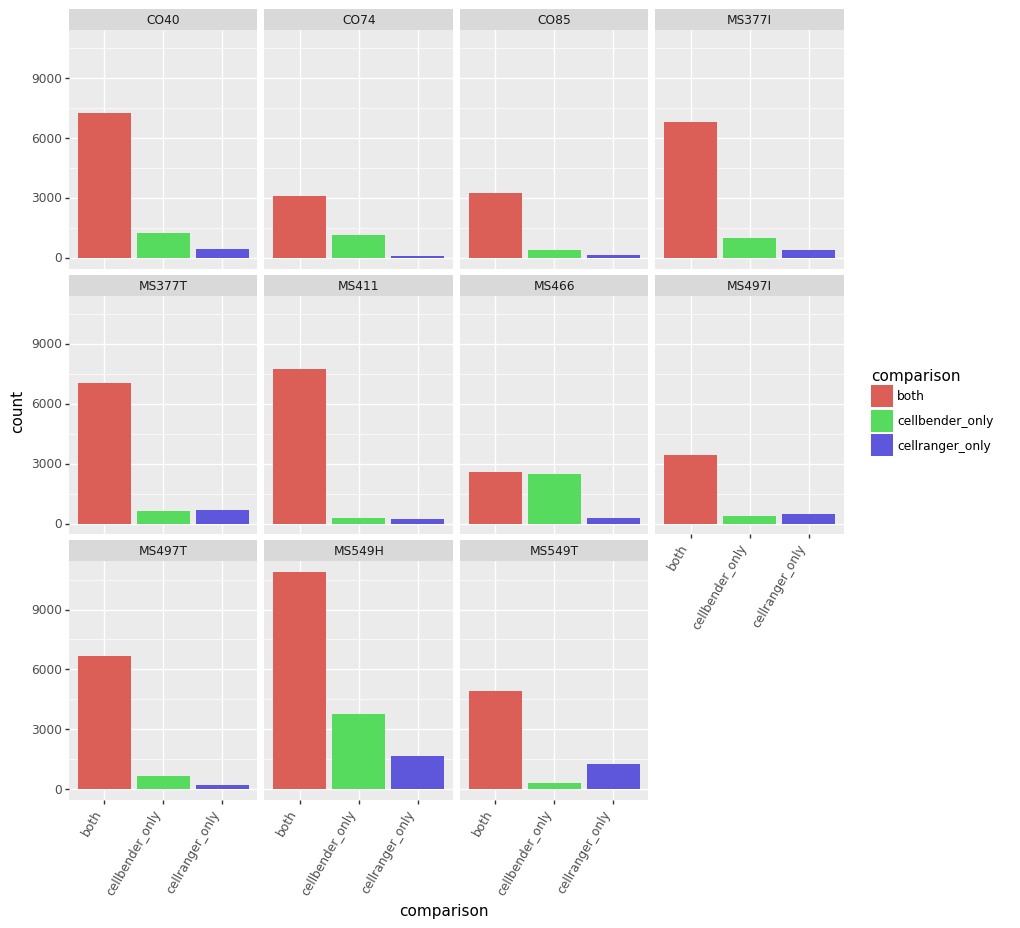

<ggplot: (8775003325046)>

In [13]:
df_list = []
for smp in np.unique(adata_cellbender.obs.sample_id):
    cellbender_set = set(adata_cellbender.obs_names[adata_cellbender.obs.sample_id == smp])
    prev_set = set(adata_cellranger.obs_names[adata_cellranger.obs.sample_id == smp])
    df_list.append(pd.DataFrame({"sample_id": smp, "both": len(cellbender_set.intersection(prev_set)), "cellbender_only": len(cellbender_set.difference(prev_set)), "cellranger_only": len(prev_set.difference(cellbender_set))}, index=[0]))
df = pd.concat(df_list)
df = df.melt(id_vars="sample_id", var_name="comparison", value_name="count")

plot = pn.ggplot(df,
          pn.aes(x= "comparison", y="count", fill="comparison")) + \
          pn.geom_bar(stat="identity") + \
          pn.facet_wrap("sample_id") + \
          pn.theme(axis_text_x=pn.element_text(rotation=60, hjust=1)) + \
          pn.theme(figure_size=(10, 10)) 
plot.save(plot_out / "sample_boxplot.png", dpi=300)
plot
            

# Comparison per Celltype (based on post QC and revious annotation)

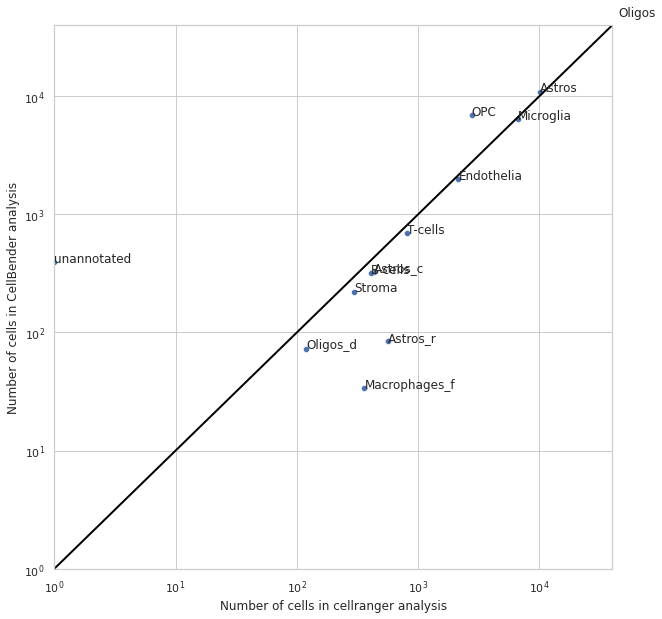

In [14]:
df = adata_cellranger.obs.cell_type.value_counts().to_frame().reset_index().rename(columns={"count": "n_cellranger"}).merge(
    adata_cellbender.obs.cell_type.value_counts().to_frame().reset_index().rename(columns={"count": "n_cellbender"}),
    on="cell_type", how="outer"
)
# replace NaNs with 1
df = df.fillna(1)

plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
plt.plot([0, 40000], [0, 40000], linewidth=2, color="black")
sns.scatterplot(data=df, x="n_cellranger", y="n_cellbender")
for i, row in df.iterrows():
    plt.text(row["n_cellranger"], row["n_cellbender"], row["cell_type"])
plt.xlabel("Number of cells in cellranger analysis")
plt.ylabel("Number of cells in CellBender analysis")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1, 40000)
plt.ylim(1, 40000)
plt.savefig(plot_out / "celltype_scatter.png", dpi=300)
plt.show()

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /home/philipp/Work/VisiumMS/scripts/process/../../out/cellbender_cellranger_comparison/celltype_boxplot.png
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you n

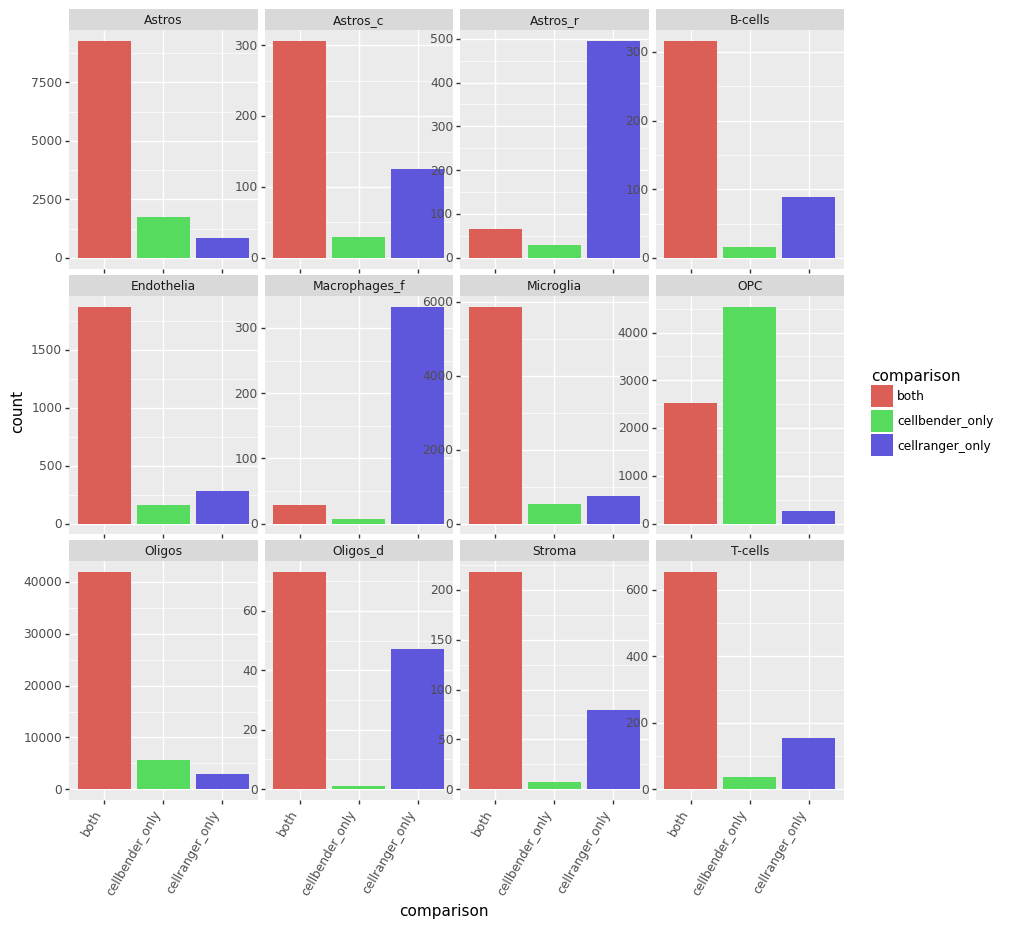

<ggplot: (8775005573997)>

In [15]:
df_list = []
for ct in np.unique(adata_cellbender.obs.cell_type_forced):
    cellbender_set = set(adata_cellbender.obs_names[adata_cellbender.obs.cell_type_forced == ct])
    prev_set = set(adata_cellranger.obs_names[adata_cellranger.obs.cell_type == ct])
    df_list.append(pd.DataFrame({"cell_type": ct, "both": len(cellbender_set.intersection(prev_set)), "cellbender_only": len(cellbender_set.difference(prev_set)), "cellranger_only": len(prev_set.difference(cellbender_set))}, index=[0]))
df = pd.concat(df_list)
df = df.melt(id_vars="cell_type", var_name="comparison", value_name="count")

plot = pn.ggplot(df,
          pn.aes(x= "comparison", y="count", fill="comparison")) + \
          pn.geom_bar(stat="identity") + \
          pn.facet_wrap("cell_type", scales="free") + \
          pn.theme(axis_text_x=pn.element_text(rotation=60, hjust=1)) + \
          pn.theme(figure_size=(10, 10)) 
plot.save(plot_out / "celltype_boxplot.png", dpi=300)
plot

# Total UMI Counts per Sample per Method

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /home/philipp/Work/VisiumMS/scripts/process/../../out/cellbender_cellranger_comparison/total_UMI_per_sample_per_method.png
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


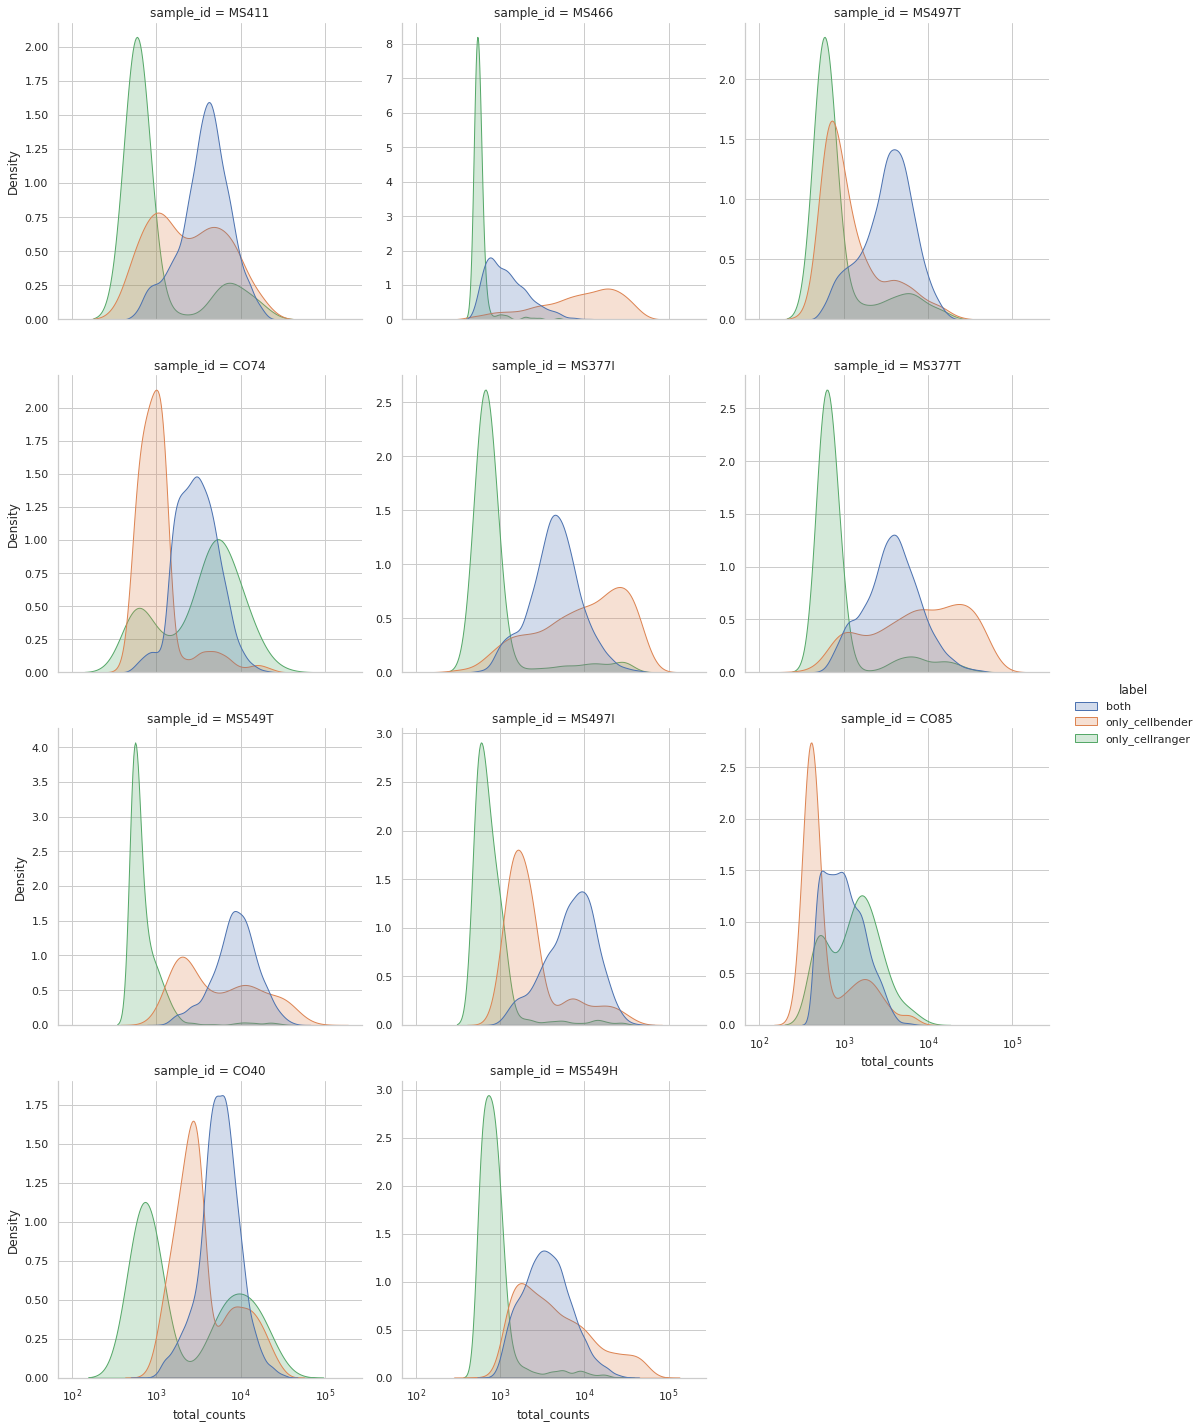

In [27]:
sns.displot(data=adata_raw.obs, x="total_counts", hue="label", kind="kde", common_norm = False, fill=True, col="sample_id", col_wrap=3, facet_kws={"sharey": False}, log_scale=True)
plot.save(plot_out / "total_UMI_per_sample_per_method.png", dpi=300)
plt.show()